## Group Project Report - Algerian Forest Fires
Ivena Du, Serena Szeto, Sophie Song, Ella Chan

In [3]:
library(tidyverse)
library(repr)
library(GGally)
library(broom)
library(digest)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)
set.seed(3456) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ dials     0.0.9      ✔ rsample   0.0.7 

# Title: Exploring and Predicting Forest Fires in Algeria Using Temperature and Rain Data

### Introduction:
The goal of the project is to predict forest fires in Algeria using relevant climate characteristics. We will work with the Algerian Forest Fires dataset, which consists of a total of 244 days worth of observations situated in two Algerian regions (Faroudja, 2019). There are 11 attributes and one output attribute. The output is classified as either fire (138 classes) or not fire (106 classes).

Fire behaviour is normally observed through components of fuel moisture and weather conditions. The Forest Fire Weather Index (FWI) is a system that consists of six components: three fuel moisture codes and three fire behaviour indices (Cortez et al., 2007). Calculations of these components are based on daily weather observations.

Here are what the column headings mean:
* day/month/year: indicate the day/month/year that the observation was taken, respectively.
* Temperature: Maximum Temperature on that day (Celsius)
* RH: Relative Humidity (%)
* Ws: Wind Speed (km/h)
* Rain: Total that day (mm)
* FFMC: Fine Fuel Moisture Code Index from FWI system
* DMC: Duff Moisture Code Index from FWI system
* DC: Drought Code Index from FWI system
* ISI: Initial Spread Index from FWI system
* BUI: Buildup index from FWI system
* FWI: Fire Weather Index
* Classes: either "not fire" or "fire"

Ultimately, we tried to answer the question: Can we predict forest fires in Algeria using weather observations?

### Methods and Results:

#### 1) Data was loaded in from the web to R.

In [4]:
forest_fire_data_raw <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1) #row 1 was skipped

#### 2) Wrangling and Cleaning the Data.
* The data is not in a tidy form as the data actually contains two regions of observations. Rows 1-122 are observations for the Bejaia Region, while rows 125 to 246 are for the Sidi-Bel Abbes Region (rows 123 and 124 contain column headers). To tidy this, an extra column called "region" will be created. After this all observations will be tidy, as they are split into individual rows, each column is a single variable and each value is in a single cell.
* We also noticed that for the 14/07/2012 data point (row 166 for the forest_fire_data_tidy dataframe) in the Sidi-Bel Abbes Region, the original dataset had a typo in it, where they forgot the delim between the ISI and BUI columns. To fix this, we removed that datapoint and replaced it with one that is correctly written (but did not change the values).
* Additionally, to make the data more usable, we decided to convert some of the columns from characters to factors (Classes) and numeric values (Temperature:FWI).

In [5]:
# We first collected the tables from the web to be able to work with them more easily.
forest_fire_data_collect <- collect(forest_fire_data_raw)

# We then seperated out the Bejaia Region and created a new "regions" column.
forest_fire_data_bejaia <- forest_fire_data_collect %>% 
    slice(1:122) %>%
    mutate(region = "Bejaia")

# We then seperated out the Sidi-Bel Abbes Region and created a new "regions" column.
forest_fire_data_sidibel <- forest_fire_data_collect %>% 
    slice(125:246) %>%
    mutate(region = "Sidi-Bel_Abbes")

# Combining the two tables produced above.
forest_fire_data_tidy <- rbind(forest_fire_data_bejaia,forest_fire_data_sidibel) 

# Fixing the broken row for 14/07/2012 observation.
forest_fire_fix <- forest_fire_data_tidy %>% 
    slice(-166) %>%
    add_row(day = "14", month = "07", year = "2012", Temperature = "37",RH = "37",Ws = "18",Rain = "0.2",FFMC = "88.9",DMC = "12.9",DC = "14.6",ISI = "9", BUI = "12.5", FWI = "10.4", Classes = "fire",region = "Sidi-Bel_Abbes")

# Mutating the numeric values into as.numerics. 
forest_fire_data_mutated <- forest_fire_fix %>% 
    mutate(Temperature = as.numeric(Temperature),
           RH = as.numeric(RH),
           Ws = as.numeric(Ws),
           Rain = as.numeric(Rain),
           FFMC = as.numeric(FFMC),
           DMC = as.numeric(DMC),
           DC = as.numeric(DC),
           ISI = as.numeric(ISI),
           BUI = as.numeric(BUI),
           FWI = as.numeric(FWI))

# Grouping the Classes column into just "fire" and "not fire." Converting the Classes column into a factor.
forest_fire_categories <- forest_fire_data_mutated %>% 
    mutate(Classes = ifelse(Classes == "fire" | Classes == "fire   " | Classes == "fire "| Classes == "fire  "|Classes == "fire   ", "fire", "not fire")) %>%
    mutate(Classes = as.factor(Classes))

##### Table 1. Cleaned Forest Fire Data

In [6]:
forest_fire_categories

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,region
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,Sidi-Bel_Abbes
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire,Sidi-Bel_Abbes
14,07,2012,37,37,18,0.2,88.9,12.9,14.6,9.0,12.5,10.4,fire,Sidi-Bel_Abbes


* Finally, we split the data into a 75% training and 25% testing set. We chose this split data in this way as our data set is quite small, and therefore we had to use a greater proportion of our data for training the model.

In [7]:
# 75% of the data was used as training data in this analysis

forest_split <- initial_split(forest_fire_categories,
                              prop = 0.75,
                              strata = Classes) # Splitting the data with 75% for training and 25% for testing.
forest_fire_training <- training(forest_split)   
forest_fire_testing <- testing(forest_split)

#### 3) Summary of Data Set for Exploratory Analysis:
* We decided to summarize the mean values of the temperature, relative humidity, wind speed and rain columns to investigate what magnitude of values each variable was in.
* We decided to exclude the FWI components and FWI because these components are calculated and assess the risk of fire. In a sense, we felt that it would not make sense to use a pre-existing algorithm or calculations to train our model. This is why we only considered summarizing and visualizing the raw weather measurements. Additionally, other studies predicting forest fires have found that models that do not use the FWI in their predictions are more accurate in comparison to models that use FWI (Cortez et al., 2007).
* We also summarized the total number of observations in each class to explore the way the training data was split.

In [8]:
forest_fire_summary <- forest_fire_training %>% 
    summarize(mean_temperature = mean(Temperature), # Computing the means of the predictors.
              mean_rh = mean(RH),
              mean_ws = mean(Ws),
              mean_rain = mean(Rain)) %>%
    mutate(total_number_of_observations = nrow(forest_fire_training)) %>% # Counting the total number of observations used in the training data set.
    mutate(fire_number_of_observations = nrow(filter(forest_fire_training, Classes == "fire"))) %>% # Counting the number of fire observations used in the training data set.
    mutate(not_fire_number_of_observations = total_number_of_observations - fire_number_of_observations) # Computing the number of not fire observations used in the training data set.

##### Table 2. Summary of Forest Fire Training Data

In [9]:
forest_fire_summary

mean_temperature,mean_rh,mean_ws,mean_rain,total_number_of_observations,fire_number_of_observations,not_fire_number_of_observations
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
32.16304,62.26087,15.65217,0.736413,184,104,80


Table 2 shows us that the variables have very different magnitudes. This suggests that in later analysis, scaling and centering may need to be done. It also shows us that we have slightly more fire observations than no fire observations, which may lead to bias in our later analysis.

#### 4) Visualizations of Data Set for Exploratory Analysis:
* We decided to create histograms of each variable to visually determine which variables are able to differentiate from fire and non-fire classes. For these histograms, we put the weather observation along the x-axis and the count along the y-axis. The observations were then colored by class.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



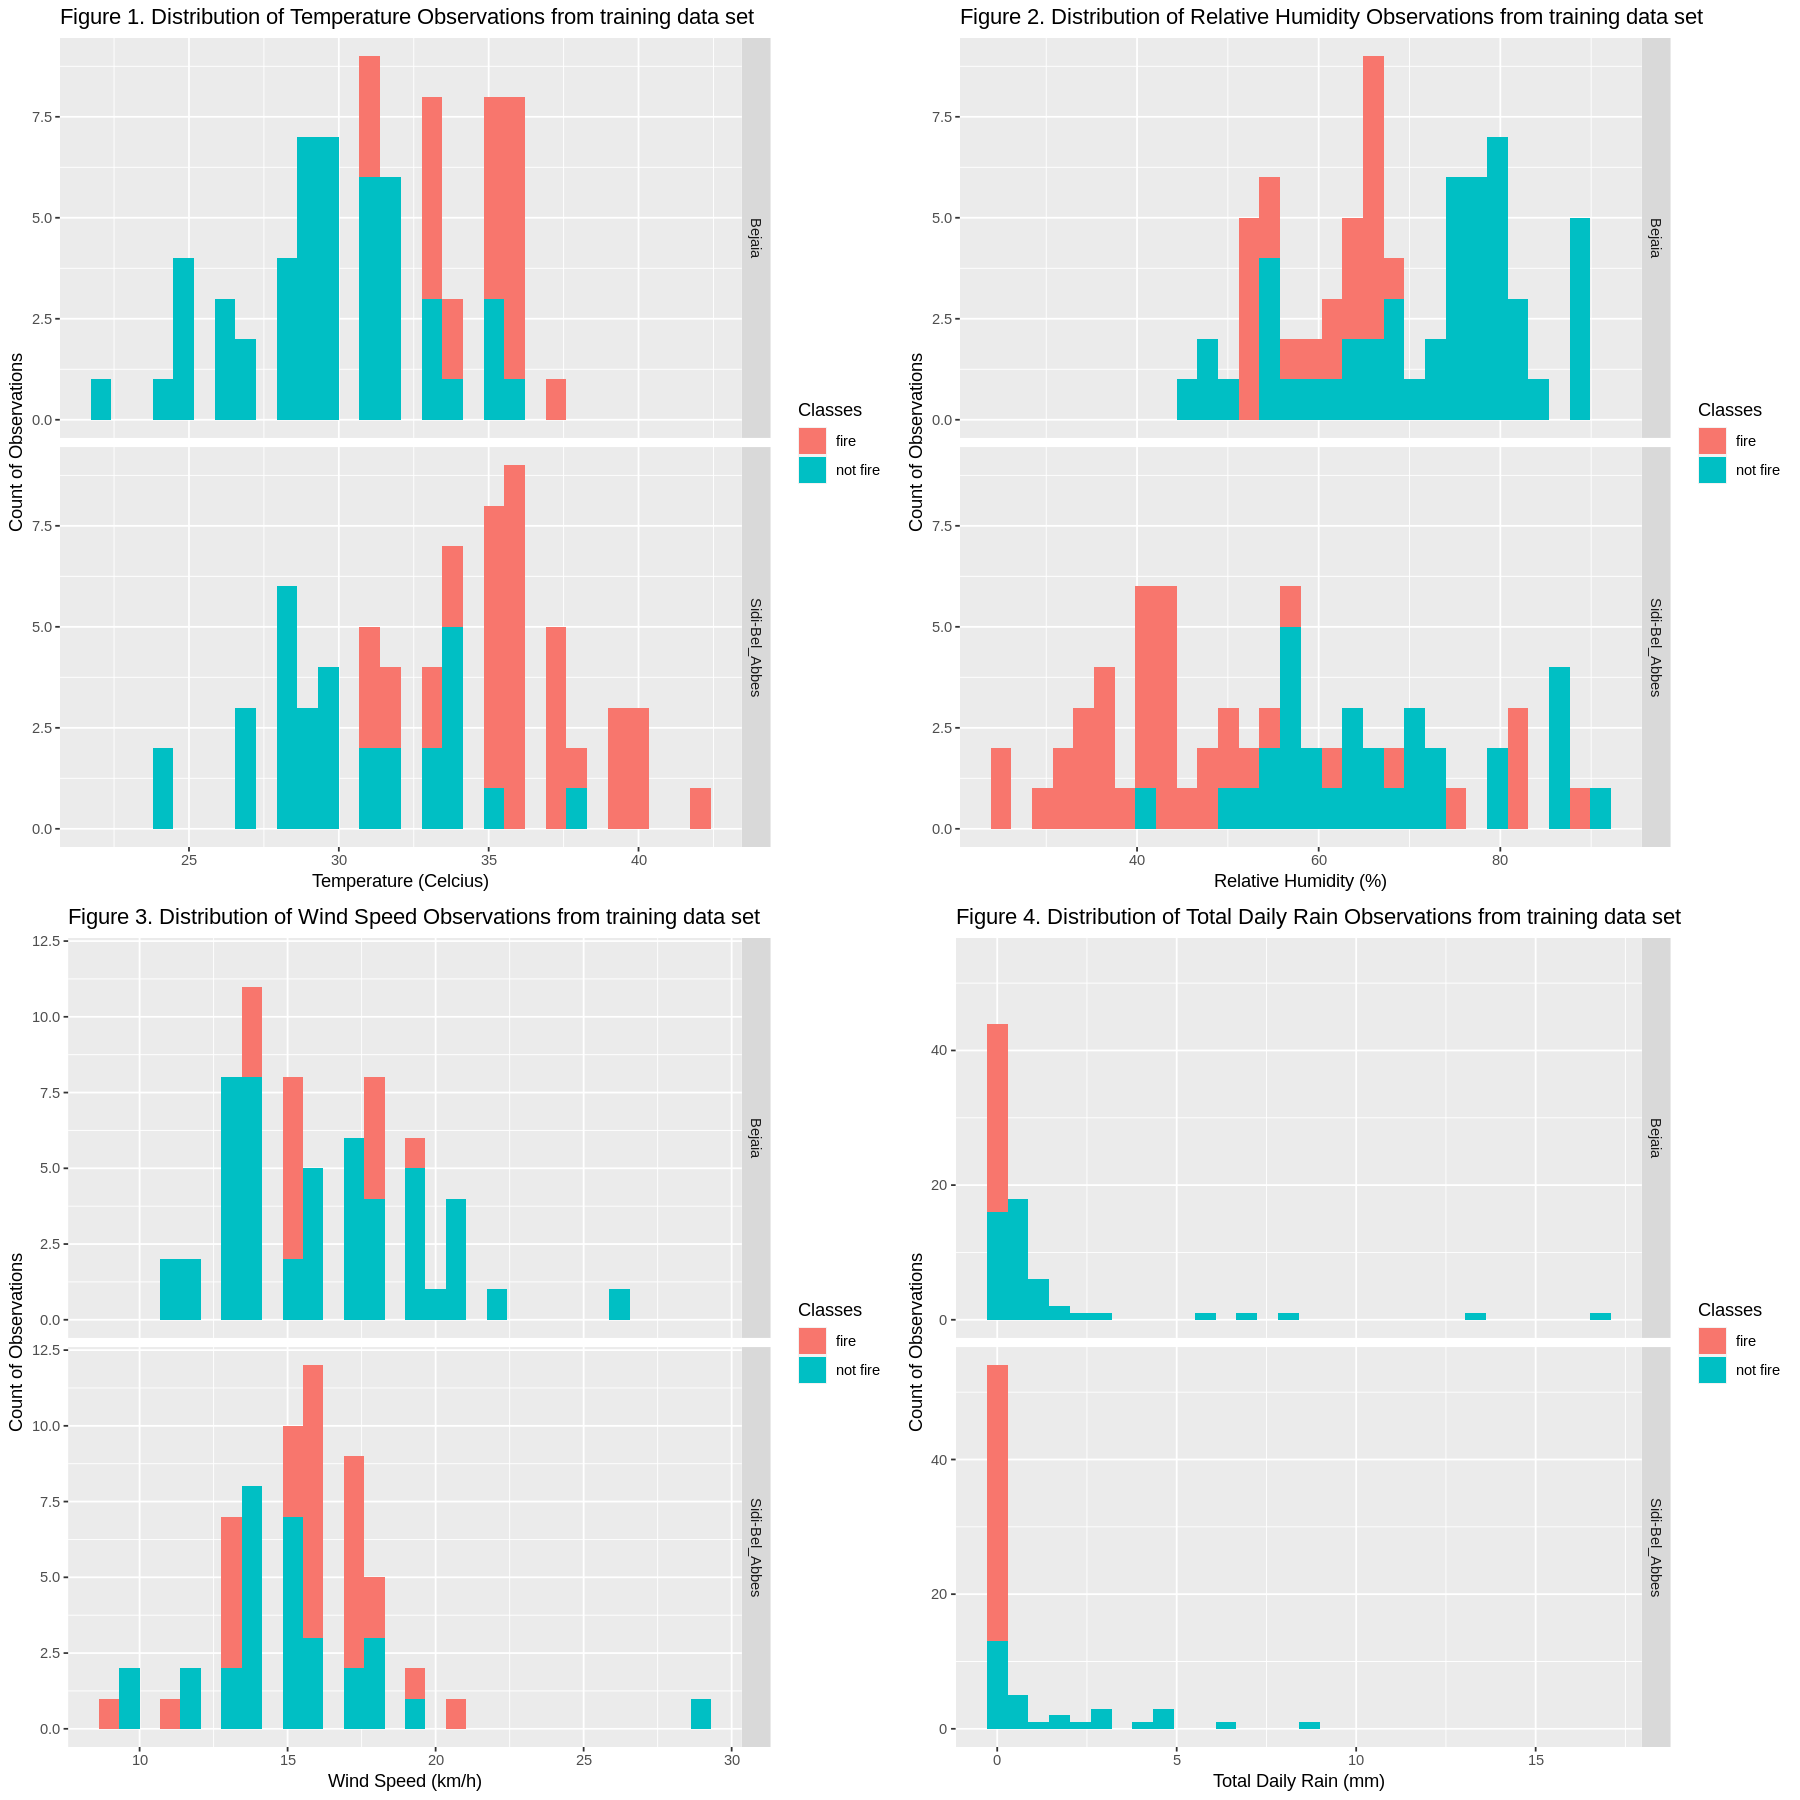

In [10]:
forest_fire_visualization_temperature <- forest_fire_training %>%
    ggplot(aes(x = Temperature, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Temperature (Celcius)", y = "Count of Observations",
         title = "Figure 1. Distribution of Temperature Observations from training data set")

forest_fire_visualization_RH <- forest_fire_training %>%
    ggplot(aes(x = RH, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Relative Humidity (%)", y = "Count of Observations",
         title = "Figure 2. Distribution of Relative Humidity Observations from training data set")

forest_fire_visualization_Ws <- forest_fire_training %>%
    ggplot(aes(x = Ws, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Wind Speed (km/h)", y = "Count of Observations",
         title = "Figure 3. Distribution of Wind Speed Observations from training data set")

forest_fire_visualization_Rain <- forest_fire_training %>%
    ggplot(aes(x = Rain, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Total Daily Rain (mm)", y = "Count of Observations",
         title = "Figure 4. Distribution of Total Daily Rain Observations from training data set")

options(repr.plot.height = 15, repr.plot.width  = 15)

plot_grid(forest_fire_visualization_temperature,
          forest_fire_visualization_RH,
          forest_fire_visualization_Ws,
          forest_fire_visualization_Rain,
          ncol = 2)

From Figures 1 to 4, we can observe that of the variables we can use to predict if there is a fire or not, the temperature and total daily rain variables show the greatest separation between the two classes. This is because the two classes are distinctly split in the histograms. For this reason, we chose to proceed with these two variables in our model, instead of using all numerical variables in our prediction. Additionally, selecting only two variables for our prediction allows for easier visualization of the model (step 6).

#### 5) Performing the Data Analysis
* We decided to use k-nearest neighbours classification for this report, as we wanted to see if we could classify conditions as "fire" or "non-fire" conditions.
* We used a 10 fold cross-validation to explore the data, as we wanted to ensure that K-values produced were the most accurate. We had the option of either 5 or 10 fold, but since our data set is not too large, we decided to do a 10 fold to get a more accurate estimate. Furthermore, since our data set is relatively small, the additional computation time required to perform a 10 fold cross-validation is not too large.

In [11]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fire_recipe <- recipe(Classes ~ Temperature + Rain, data = forest_fire_training) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

fire_vfold <- vfold_cv(forest_fire_training, v = 10, strata = Classes)

fire_results <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = fire_vfold, grid = 20) %>%
    collect_metrics()

##### Table 3. Results of Data Analysis with Different K neighbors

In [12]:
fire_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8640351,10,0.01462151,Model01
1,roc_auc,binary,0.8619318,10,0.01506819,Model01
2,accuracy,binary,0.8807018,10,0.01311849,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.9205114,10,0.01481067,Model14
15,accuracy,binary,0.8315789,10,0.02302424,Model15
15,roc_auc,binary,0.9185795,10,0.01448017,Model15


* We then plotted the data and pulled the K with the highest level of accuracy.

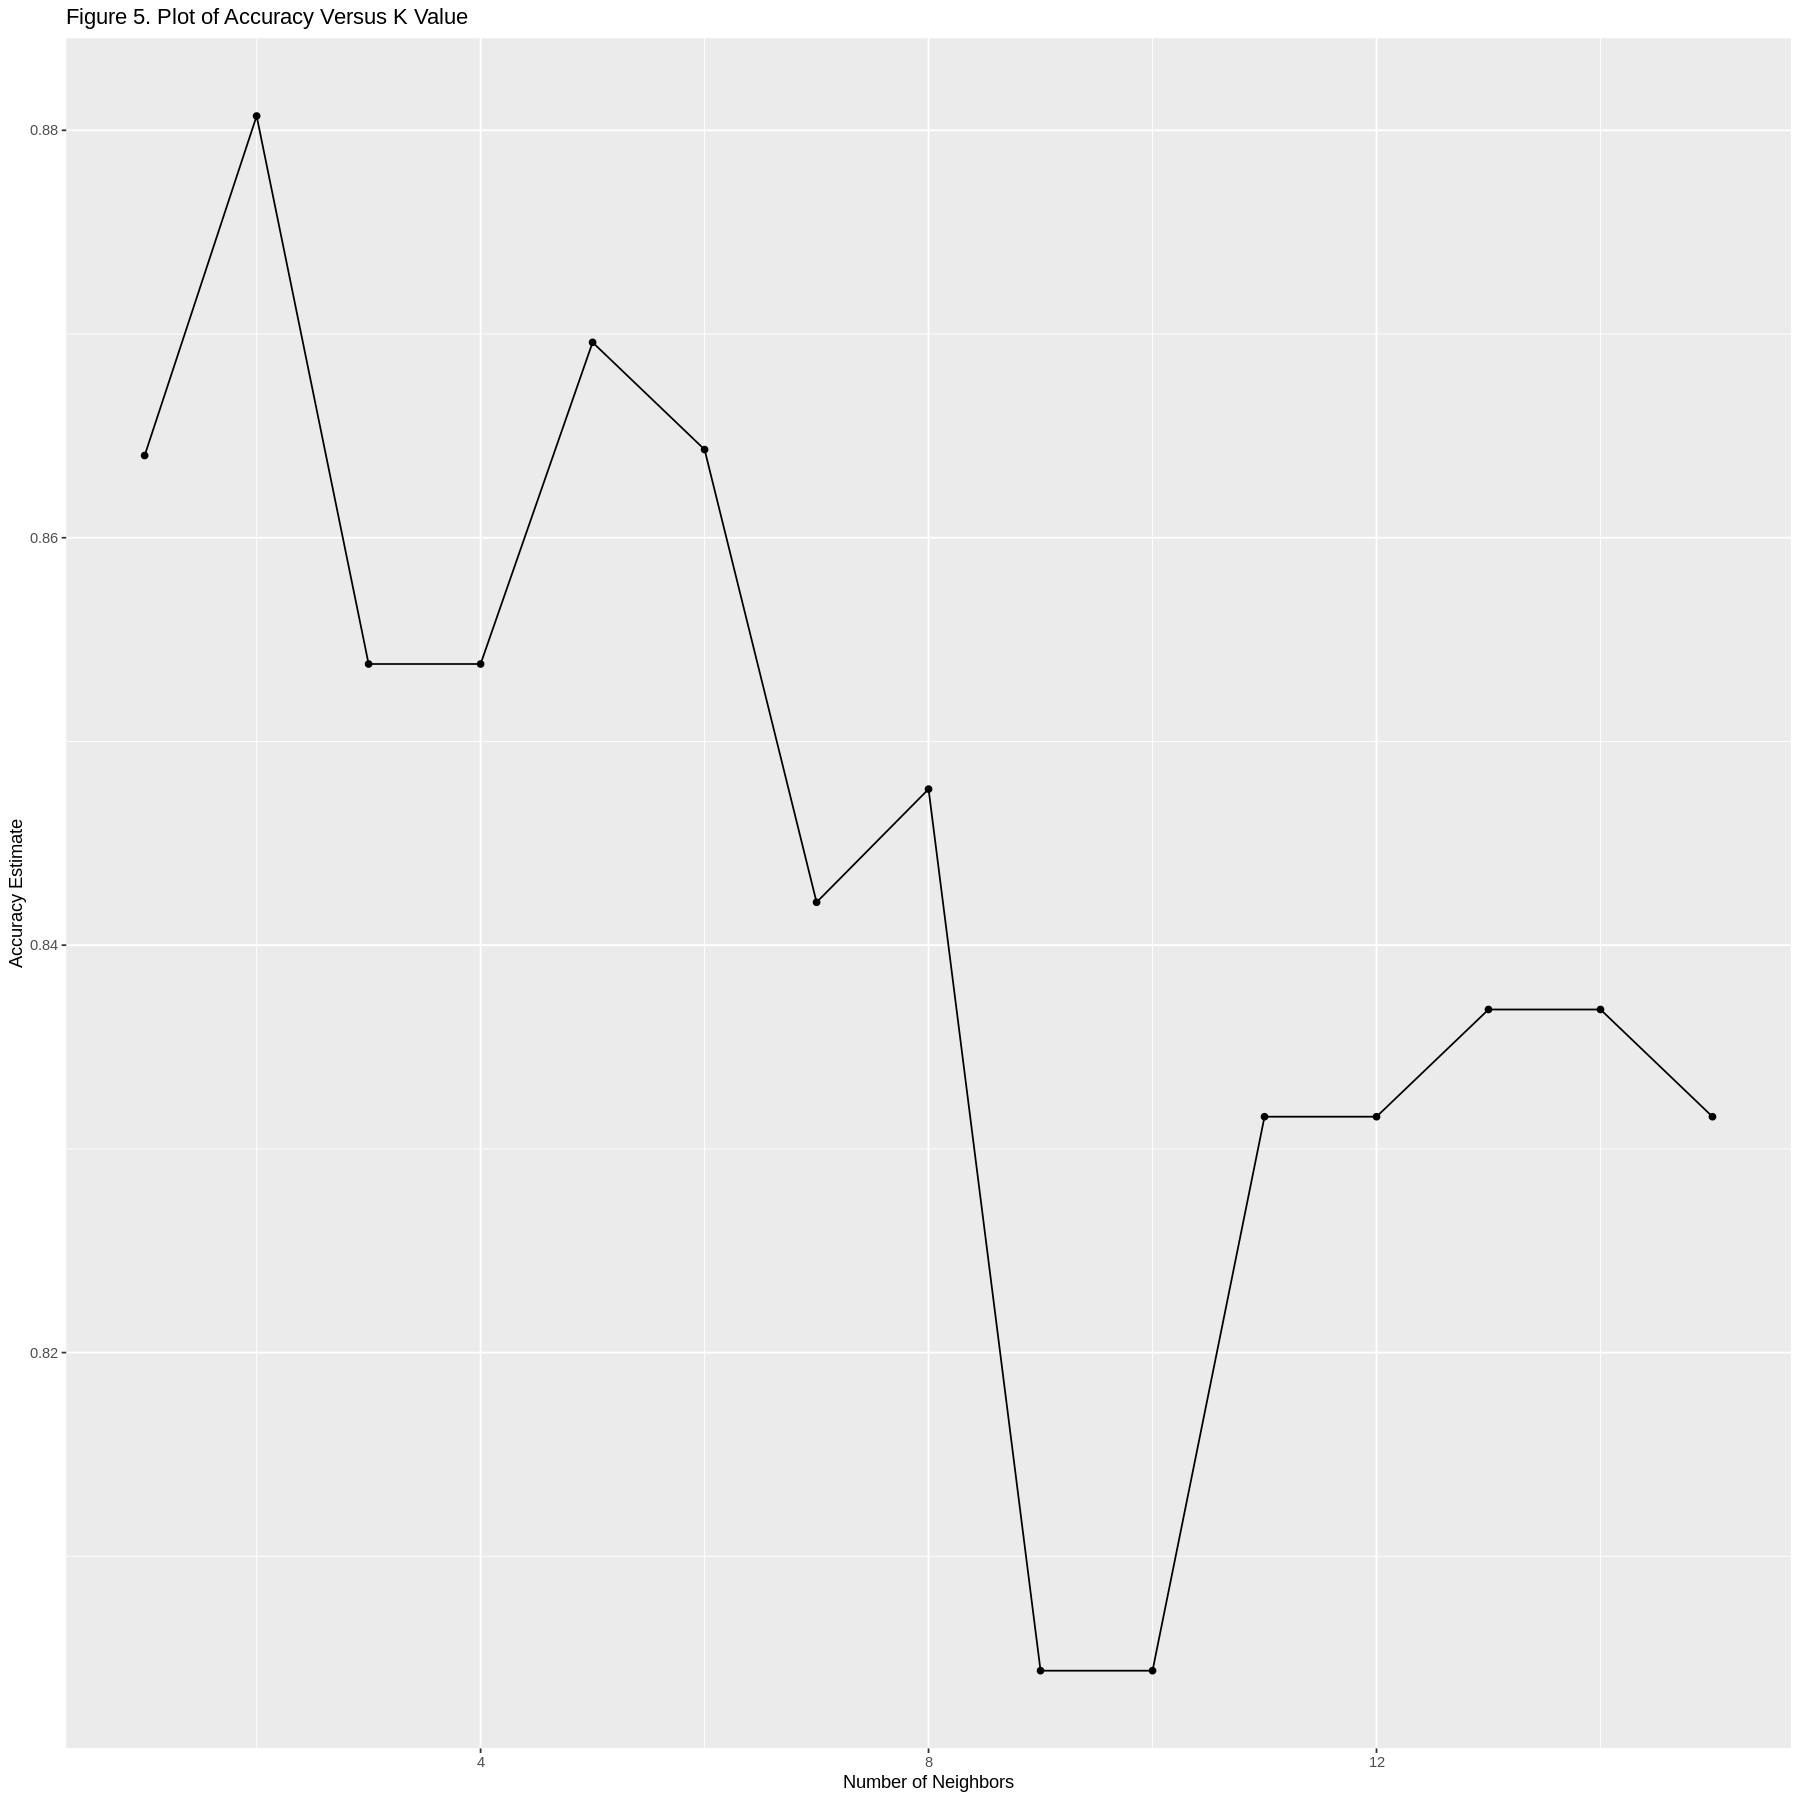

In [13]:
accuracies <- fire_results %>%
    filter(.metric == "accuracy")

accuracy_versus_k <- accuracies %>%
                     ggplot(aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Number of Neighbors", y = "Accuracy Estimate", title = "Figure 5. Plot of Accuracy Versus K Value")
accuracy_versus_k

best_estimate <- accuracies %>%
          arrange(desc(mean)) %>%
          slice(1)

From Figure 5, we decided to select the number of neighbours used to be 2, seeing as it resulted in the greatest accuracy estimate from our cross evaluation. We then added this K value to our model.

In [14]:
best_k <- best_estimate %>%
          pull(neighbors)

fire_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

fire_best_fit <- workflow() %>%
    add_recipe(fire_recipe) %>%
    add_model(fire_best_spec) %>%
    fit(data = forest_fire_training)

fire_test_result <- fire_best_fit %>%
    predict(forest_fire_testing) %>%
    bind_cols(forest_fire_testing)

fire_summary <- fire_test_result %>%
    metrics(truth = Classes, estimate = .pred_class)

##### Table 4. Summary of Data Analysis Results for tuned K.

In [15]:
fire_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.5964126


From Table 4, it is shown that the accuracy for this model on the testing set is 80% when K = 2.

#### 6) Visualizing the Data Analysis

To visualize how the prediction results vary across the data, we constructed a scatterplot of the two predictor variables, color coded the data according to the actual class labels of "Fire" and "No Fire", and colored the background of the plot according to the prediction assignments of the classifier. This allows us to visualize how the model is predicting the classes of our testing observations. Additionally, it allows us to gather information on how the model would predict other points outside of our data set.

In [16]:
rain_grid <- seq(min(forest_fire_categories$Rain), max(forest_fire_categories$Rain), length.out = 100)

temperature_grid <- seq(min(forest_fire_categories$Temperature), max(forest_fire_categories$Temperature), length.out = 100)

asgrid <- as_tibble(expand.grid(Rain = rain_grid, Temperature = temperature_grid))

pred_grid <- predict(fire_best_fit, asgrid)

prediction_table <- bind_cols(pred_grid, asgrid)

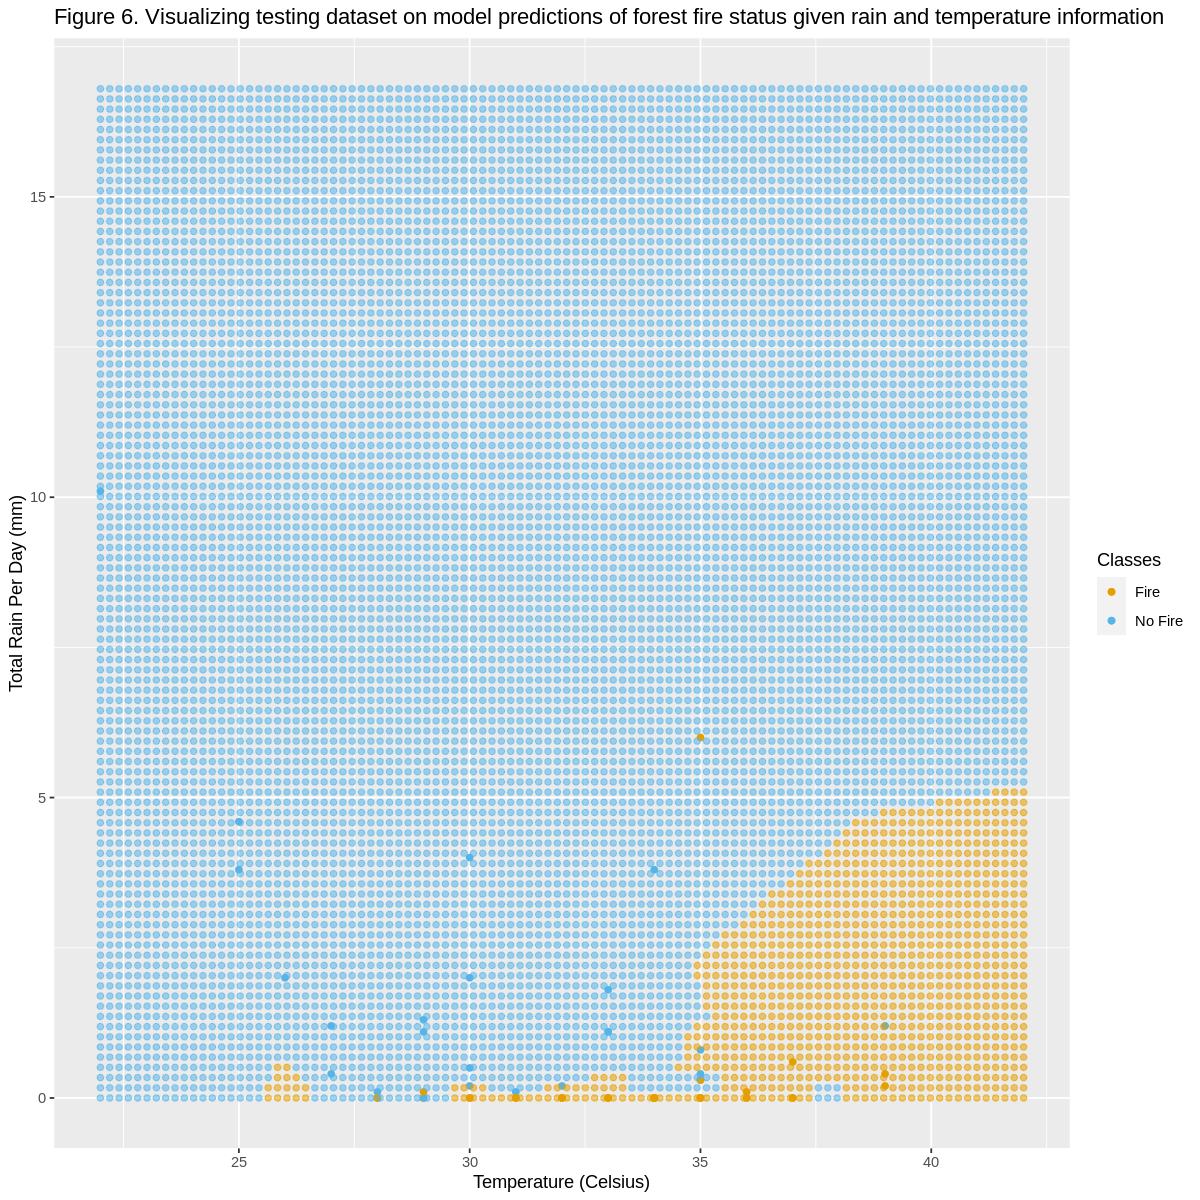

In [23]:
cbPalette <- c("#E69F00", "#56B4E9", "#009E73")

options(repr.plot.height = 10, repr.plot.width  = 10)

temp_rain_plot_r <- ggplot() +
                geom_point(data = forest_fire_testing, mapping = aes(x = Temperature, y = Rain, colour = Classes)) + 
                geom_point(data = prediction_table, mapping = aes(x = Temperature, y = Rain, colour = .pred_class, alpha = 0.1)) +
                scale_color_manual(labels = c("Fire", "No Fire"), values = cbPalette) +
                labs(x = "Temperature (Celsius)", y = "Total Rain Per Day (mm)", title = "Figure 6. Visualizing testing dataset on model predictions of forest fire status given rain and temperature information") +
                guides(alpha=FALSE)
temp_rain_plot_r

From Figure 6 we can observe that the majority of the testing set data point are predicted correctly (indicated by background colour and the point matching). However, there are a few points that are predicted incorrectly, largely for days without rain (indicated by the background colour and point colour not matching). This tells us that our model is able to predict the majority of points correctly, but does occassionally make mistakes at low rain values. In addition, the model regions displayed help us observe how our model would predict other observations. From this, we see a clear distinction between temperature and rain values where the model predicts that forest fires occur versus do not occur.

### Discussion:

In our proposal we predicted that days where there are reported fires will have: little to no rain; lower relative humidity; higher temperature; and higher FWI values (Fernandes, 2001). However, in our report, we decided to exclude most of these variables. In the markdown cell below Figures 1 to 4, we ultimately decided to exclude all variables other than temperature and total rain per day. As described in the Visualizations of Data Set for Exploratory Analysis section (Step 4), they showed the strongest relationship in terms of predicted fires. Reducing the number of predictors also allows us to visualize our findings in a much neater format. Our group found that having coloured regions for predicted classes was an extremely intuitive visualization, which we wouldn’t have been able to do with more than 2 predictors.

As shown in Figure 6, we found that fires would be predicted on days with low rain and/or high temperatures. When the temperature goes above 35, the range of rain measurements in which fires are observed becomes much wider (more rain in comparison to days with temperatures lower than 35). When the temperature is below 35, only days with extremely low rain are when fires are predicted. This aligns with our predictions, as days with higher temperature and little to no rain are predicted to have fires.

The main difference that we did not predict is that days where the temperature is not extremely high can still have predicted fires due to low amounts of rain. Although the combination of the two factors are the most likely to have predicted fires, we couldn’t predict the nuances in having high amounts of rain but high temperature or lower temperature but low amounts of rain. 

Accurate predictions would allow us to better prepare and equip firefighters for forest fires as well as lead to quicker evacuations and extinguishing of fires. This might lead us to new questions, such as whether it is possible to predict the magnitude or scale of a forest fire based on weather conditions. This question can lead us to predict what resources are necessary to combat the fire in advance and assess a general size or radius that would require evacuations.

When comparing our model to those in the literature, we observed that our selected characteristics (temperature and rainfall) are often included in other models for fire prediction (Cortez et al., 2007). This was described in our Summary of Data Set for Exploratory Analysis (Step 3).

Another study that could be proposed is the difference in these predictions for different types of forests (types of trees, climates, ecosystems), as our model which was trained with this dataset may not apply to other forests in other countries. 


### References:

Cortez, Paulo and Morais, Anibal de Jesus Raimundo. “A data mining approach to predict forest fires using meteorological data.” 
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Associação Portuguesa para a Inteligência Artificial (APPIA), Dec. 2007, http://hdl.handle.net/1822/8039

Faroudja ABID et al., Predicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithm, 
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019) , 08 - 11 July, 2019, 
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Marrakech, Morocco. https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++

Fernandes, Paulo A. Martins. “Fire Spread Prediction in Shrub Fuels in Portugal.” Forest Ecology and Management, Elsevier,
<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
22 Mar. 2001, https://www.sciencedirect.com/science/article/pii/S0378112700003637 
